In [5]:
#Import some packages to use
import cv2
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

import random
import os, shutil
import gc   #Gabage collector for cleaning deleted data from memory

train_dir_dogs = './kaggle_dogcat/train/dogs'
train_dir_cats = './kaggle_dogcat/train/cats'
test_dir = './kaggle_dogcat/test'

train_dogs = ['./kaggle_dogcat/train/dogs/{}'.format(i) for i in os.listdir(train_dir_dogs) ]  #get dog images
train_cats = ['./kaggle_dogcat/train/cats/{}'.format(i) for i in os.listdir(train_dir_cats) ]  #get cat images

path_list = os.listdir(test_dir)
path_list.sort()

test_imgs = ['./kaggle_dogcat/test/{}'.format(i) for i in path_list] #get test images

train_imgs = train_dogs + train_cats  # slice the dataset and use 2000 in each class
random.shuffle(train_imgs)  # shuffle it randomly

#Clear list that are useless
del train_dogs
del train_cats
gc.collect()   #collect garbage to save memory


['./train/resize_300_train/03', './train/resize_300_train/05', './train/resize_300_train/21', './train/resize_300_train/06', './train/resize_300_train/00', './train/resize_300_train/40', './train/resize_300_train/32', './train/resize_300_train/28', './train/resize_300_train/08', './train/resize_300_train/10', './train/resize_300_train/18', './train/resize_300_train/07', './train/resize_300_train/14', './train/resize_300_train/31', './train/resize_300_train/11', './train/resize_300_train/24', './train/resize_300_train/01', './train/resize_300_train/04', './train/resize_300_train/36', './train/resize_300_train/23', './train/resize_300_train/35', './train/resize_300_train/12', './train/resize_300_train/34', './train/resize_300_train/20', './train/resize_300_train/33', './train/resize_300_train/29', './train/resize_300_train/02', './train/resize_300_train/27', './train/resize_300_train/19', './train/resize_300_train/41', './train/resize_300_train/26', './train/resize_300_train/37', './trai

FileNotFoundError: [Errno 2] No such file or directory: './kaggle_dogcat/test'

In [21]:
#Lets declare our image dimensions
#we are using coloured images. 
nrows = 150
ncolumns = 150
channels = 3  #change to 1 if you want to use grayscale image


#A function to read and process the images to an acceptable format for our model
def read_and_process_image(list_of_images):
    """
    Returns two arrays: 
        X is an array of resized images
        y is an array of labels
    """
    X = [] # images
    y = [] # labels
    
    for image in list_of_images:
        X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (nrows,ncolumns), interpolation=cv2.INTER_CUBIC))  #Read the image
        #get the labels, dog assign "0", cat assign "1"
        if 'dogs' in image:
            y.append(0)
        elif 'cats' in image:
            y.append(1)
    
    return X, y

In [22]:
#get the train and label data
X, y = read_and_process_image(train_imgs)

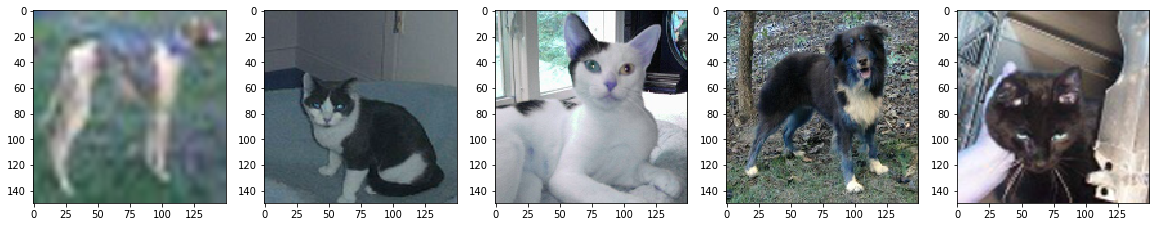

In [23]:
#Lets view some of the pics
plt.figure(figsize=(20,10))
columns = 5
for i in range(columns):
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.imshow(X[i])

Text(0.5, 1.0, 'Labels for Cats and Dogs')

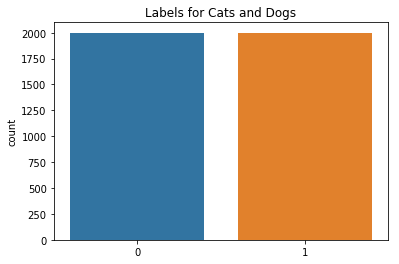

In [24]:
del train_imgs
gc.collect()
#Convert list to numpy array
X = np.array(X)
y = np.array(y)

#Lets plot the label to be sure we just have two class
sns.countplot(y)
plt.title('Labels for Cats and Dogs')

In [25]:
print("Shape of train images is:", X.shape)
print("Shape of labels is:", y.shape)

Shape of train images is: (4000, 150, 150, 3)
Shape of labels is: (4000,)


In [26]:
#Lets split the data into train and test set
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=2)

In [27]:
#clear memory
del X
del y
gc.collect()

#get the length of the train and validation data
ntrain = len(X_train)
nval = len(X_val)

#We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32  


Now lets create our model.

In [28]:
#Using transfer learning InceptionResNetV2

from keras.applications import InceptionResNetV2

conv_base = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(150,150,3))

In [29]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_407 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_407 (BatchN (None, 74, 74, 32)   96          conv2d_407[0][0]                 
__________________________________________________________________________________________________
activation_407 (Activation)     (None, 74, 74, 32)   0           batch_normalization_407[0][0]    
__________________________________________________________________________________________________
conv2d_408

In [30]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))  #Sigmoid function at the end because we have just two classes

In [31]:
#Lets see our model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 3, 3, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 13824)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               3539200   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 57,876,193
Trainable params: 57,815,649
Non-trainable params: 60,544
_________________________________________________________________


In [32]:
print('Number of trainable weights before freezing the conv base:', len(model.trainable_weights))
conv_base.trainable = False
print('Number of trainable weights after freezing the conv base:', len(model.trainable_weights))


Number of trainable weights before freezing the conv base: 492
Number of trainable weights after freezing the conv base: 4


In [33]:
#We'll use the RMSprop optimizer with a learning rate of 0.0001
#We'll use binary_crossentropy loss because its a binary classification
from keras import optimizers

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['acc'])

In [34]:
#Lets create the augmentation configuration
#This helps prevent overfitting, since we are using a small dataset
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img

train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [35]:
#Create the image generators
train_generator = train_datagen.flow(X_train, y_train,batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [37]:
#The training part
#train for 64 epochs with about 100 steps per epoch
history = model.fit_generator(train_generator,
                              steps_per_epoch=ntrain // batch_size,
                              epochs=64,
                              validation_data=val_generator,
                              validation_steps=nval // batch_size)

Epoch 1/64
100/100 [==============================] - 26s 263ms/step - loss: 0.3778 - acc: 0.8234 - val_loss: 0.4263 - val_acc: 0.9137
Epoch 2/64
100/100 [==============================] - 26s 261ms/step - loss: 0.3527 - acc: 0.8481 - val_loss: 0.2849 - val_acc: 0.9450
Epoch 3/64
100/100 [==============================] - 26s 261ms/step - loss: 0.3446 - acc: 0.8459 - val_loss: 0.2346 - val_acc: 0.9525
Epoch 4/64
100/100 [==============================] - 26s 261ms/step - loss: 0.3323 - acc: 0.8519 - val_loss: 0.2854 - val_acc: 0.9475
Epoch 5/64
100/100 [==============================] - 26s 261ms/step - loss: 0.3285 - acc: 0.8516 - val_loss: 0.3347 - val_acc: 0.9300
Epoch 6/64
100/100 [==============================] - 26s 261ms/step - loss: 0.3382 - acc: 0.8444 - val_loss: 0.2748 - val_acc: 0.9450
Epoch 7/64
100/100 [==============================] - 26s 261ms/step - loss: 0.3197 - acc: 0.8666 - val_loss: 0.5231 - val_acc: 0.9175
Epoch 8/64
100/100 [==============================] - 2

In [38]:
#Save the model
model.save_weights('model_wieghts_epoch64.h5')
model.save('model_keras_epoch64.h5')

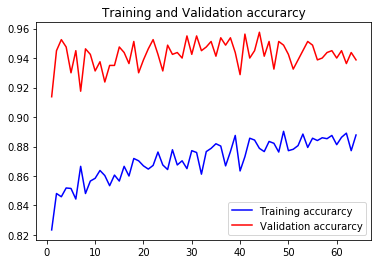

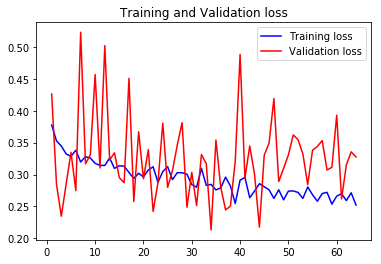

In [39]:
#lets plot the train and val curve
import matplotlib.pyplot as plt

#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()

plt.show()


Let's create a function that makes our plot looks smoother and cleaner.

In [40]:
#Now lets predict on the first 10 Images of the test set

#test_imgs = ['./kaggle_dogcat/test/{}'.format(i) for i in os.listdir(test_dir).sort()] #get test images
X_test, y_test = read_and_process_image(test_imgs) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

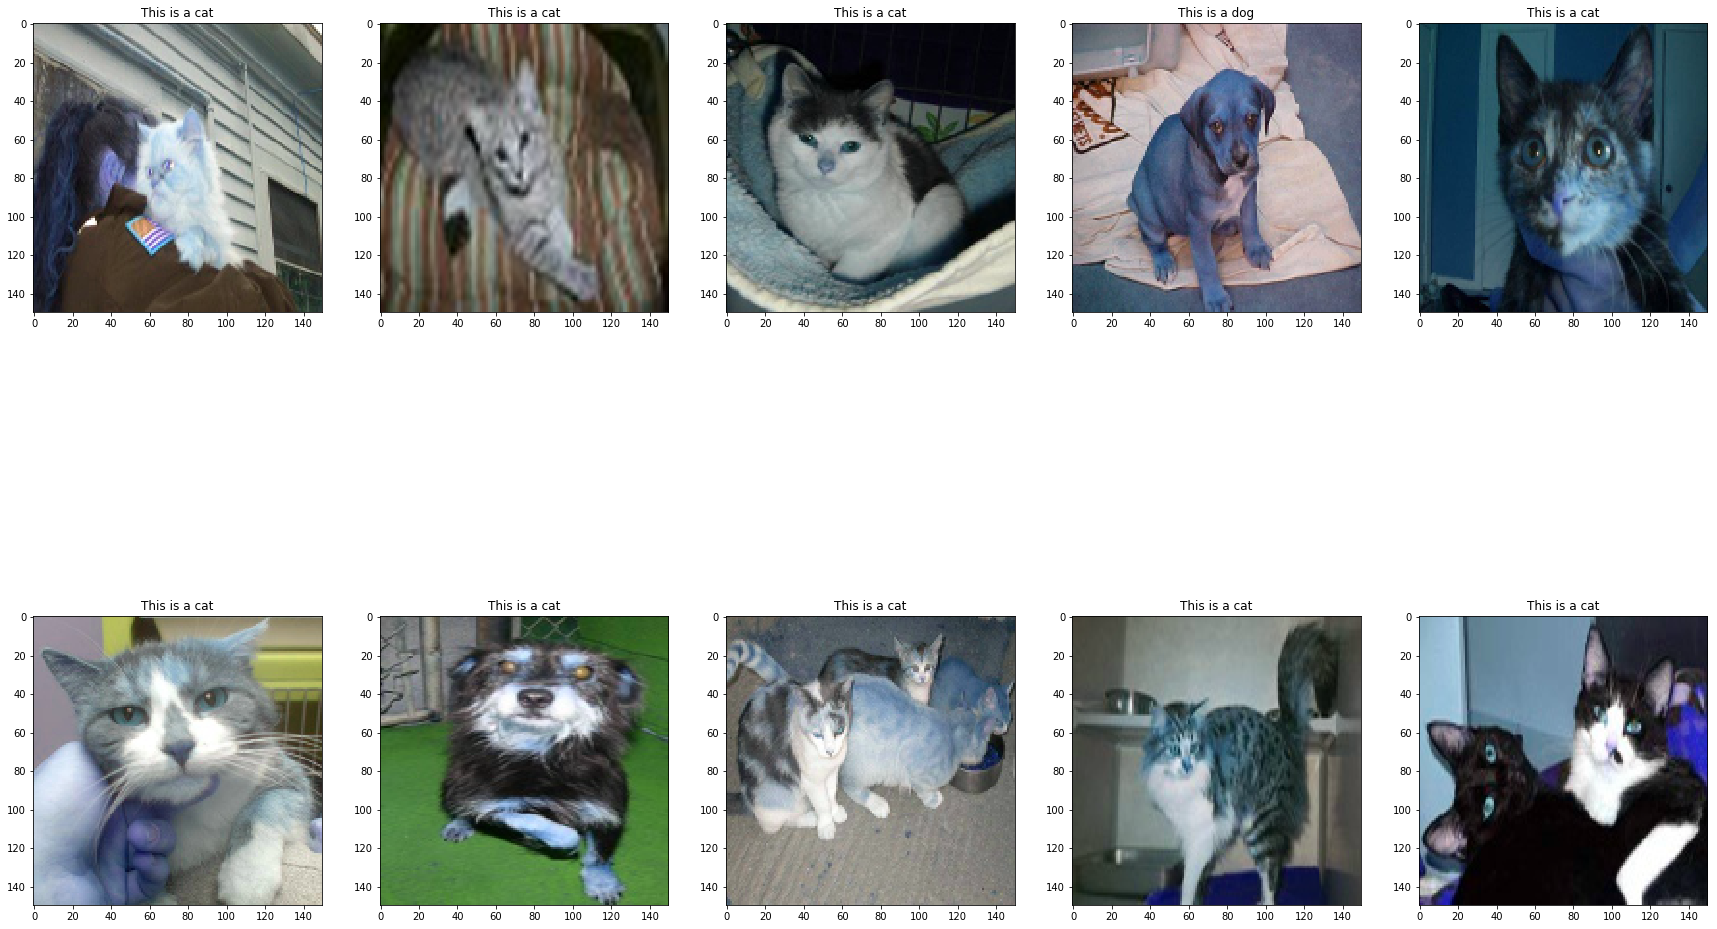

In [41]:
i = 0
columns = 5
text_labels = []
plt.figure(figsize=(30,20))
#pred = model.predict(x)
for batch in test_datagen.flow(x, batch_size=1,shuffle= False):
    pred = model.predict(batch)
    if pred > 0.5:
        text_labels.append('cat')
    else:
        text_labels.append('dog')
    plt.subplot(5 / columns + 1, columns, i + 1)
    plt.title('This is a ' + text_labels[i])
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 10 == 0:
        break
plt.show()

A [link](https://medium.com/@risingdeveloper/transfer-learning-on-image-classification-using-keras-and-kaggle-kernels-c76d3b030649) to my Medium post with full explanation of the code and transfer learning in general

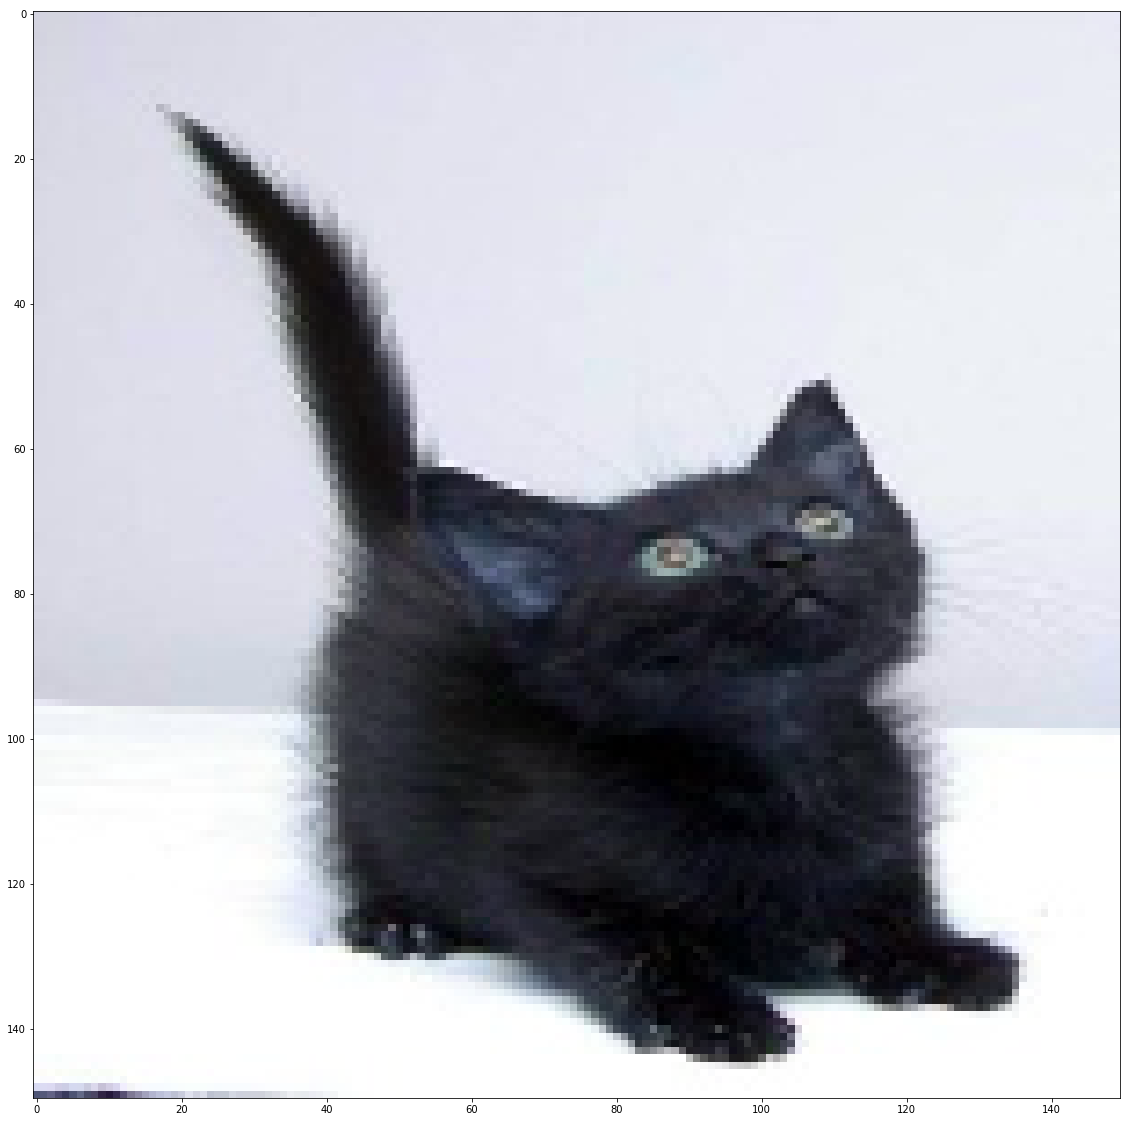

In [42]:
#Now lets predict on the first 10 Images of the test set
X_test, y_test = read_and_process_image(test_imgs) #Y_test in this case will be empty.
x = np.array(X_test)
test_datagen = ImageDataGenerator(rescale=1./255)

i = 0
text_labels = []
pred_labels = []
plt.figure(figsize=(30,20))
for batch in test_datagen.flow(x, batch_size=1,shuffle= False):
    pred = model.predict(batch)
    pred_labels.append(pred)
    imgplot = plt.imshow(batch[0])
    i += 1
    if i % 400== 0:
        break
#plt.show()


#lets save our prediction and submit
counter = range(0, len(test_imgs))
#print(counter)
df_solution = pd.DataFrame({"ID": counter, "Predicted":list(pred_labels)})
cols = ['Predicted']

for col in cols:
    df_solution[col] = df_solution[col].map(lambda x: str(x).lstrip('[').rstrip(']')).astype(float)

df_solution.to_csv("submissiondogsVScats.csv", index = False)
